## HOMEWORK 4  ADM
### 2.1: Getting your data + feature engineering

##### 2.1.1: Accessing to the dataset

In [136]:
import pandas as pd
import numpy as np

#Reading the original dataset of Kaggle
path = r"C:\Users\sofyc\OneDrive\Desktop\Homework4_adm\df_uk_movies.csv"
df = pd.read_csv(path)

#General info
print(df.shape) #dimensions
print(df.columns) #names of the columns
df.head()

(671736, 8)
Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')


,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [138]:
#Control about the NaNs values in the columns
print(df['user_id'].isna().sum()) #0
print(df['title'].isna().sum()) #0
print(df['movie_id'].isna().sum()) #0
print(df['genres'].isna().sum()) #0
print(df['datetime'].isna().sum()) #0
print(df['release_date'].isna().sum()) #0
print(df['duration'].isna().sum()) #0

#Just to be sure
df=df.dropna(subset=['user_id'])

0
0
0
0
0
0
0


#### 2.1.2: Feature engineering of the first 5 variables

In [139]:
#To be sure that the columns 'datetime' and 'release_date' are in the correct forms
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

#Creating the variables:
#a) Favourite genre (i.e., the genre on which the user spent the most time)
df = df.assign(genres = df['genres'].str.split(',')).explode('genres') #There are more genres in a row
fav_genre = df.groupby('user_id')['genres'].agg(lambda x: x.value_counts().idxmax())

#b) Average click duration
avg_duration = df.groupby('user_id')['duration'].mean()

#c) Time of the day when the user spends the most time on the platform
#The modalities are: 1 for "Morning", 2 for "Afternoon", 3 for "Night"
df['hourofday'] = 0
df['hourofday'] = df.datetime.dt.hour #Taking just the hour
conditions = [
   (df['hourofday'] >= 0) & (df['hourofday'] < 12), # Morning
   (df['hourofday'] >= 12) & (df['hourofday'] < 18), # Afternoon
   (df['hourofday'] >= 18) & (df['hourofday'] <= 24) # Night
]

choices = [1, 2, 3]

df['hourofday'] = np.select(conditions, choices, default='Invalid')
time_day = df.groupby('user_id')['hourofday'].agg(lambda x: x.value_counts().idxmax())

#d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?
#The modalities are: 1 for "Old movie lover" and 2 for "Recent movie lover"
df['release_category'] = np.where(df['release_date'].dt.year < 2010, 1, 2)
movie_pref = df.groupby('user_id')['release_category'].agg(lambda x: x.value_counts().idxmax())

#e) Average time spent a day by the user
#.dt.date to consider just the date and not the time
avg_daily = df.groupby(['user_id', df['datetime'].dt.date])['duration'].sum().groupby('user_id').mean()


In [140]:
#New resulting dataframe
new_df = pd.DataFrame({
    'Favourite Genre': fav_genre,
    'Average Click Duration': avg_duration,
    'Time of Day': time_day,
    'Movie Preference': movie_pref,
    'Average Time per Day': avg_daily
})

#Assigning the index to a column
new_df['user_id'] = new_df.index
#Removing the index
new_df = new_df.reset_index(drop=True)

#Trasforming the column 'Average Click Duration' in minutes
new_df['Average Click Duration'] = (new_df['Average Click Duration'] / 60).round(2)
#Trasforming the column 'Average Time per Day' in minutes
new_df['Average Time per Day'] = (new_df['Average Time per Day'] / 60).round(2)

#Final dataset
new_df #161918 rows x 6 columns

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id
0,Crime,0.00,3,1,0.00,00004e2862
1,Thriller,36.92,3,2,339.64,000052a0a0
2,Mystery,0.00,3,2,0.00,000090e7c8
3,NOT AVAILABLE,-0.00,1,2,-0.01,000118a755
4,Drama,161.06,3,2,2576.90,000296842d
...,...,...,...,...,...,...
161913,Documentary,141.58,3,2,424.75,fffd9bf758
161914,Drama,29.75,2,2,89.25,fffe7b777b
161915,Documentary,656.02,3,2,1968.08,fffeac83be
161916,Documentary,0.00,2,1,0.00,ffff2c5f9e


#### 2.1.3: Feature engineering of the others 10 variables

In [141]:
#1) Most frequent day of week
df['day'] = df['datetime'].dt.day_name()  #Taking just the day

#Mapping the days of the week with numbers: 1 for Monday, 2 for Tuesday, 3 for Wednesday, 4 for Thursday, 5 for Friday, 6 for Saturday, 7 for Sunday
day_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

#Finding the most frequent day for every user in the numeric form
day_freq = df.groupby('user_id')['day'].agg(lambda x: x.map(day_mapping).value_counts().idxmax())

#Adding the column 'Frequent day' to new_df
new_df['Frequent day'] = new_df['user_id'].map(day_freq)


In [142]:
#2) Number of different genres clicked by the user
#This feature can be useful to understand the user's diverse interests.
df['genres_listo']= df['genres']
df = df.assign(genres_listo = df['genres_listo'].str.split(',')).explode('genres_listo') #There are more genres in a row
number_genre = df.groupby('user_id')['genres_listo'].nunique()

#Adding the column 'number_genres' to new_df
new_df['number_genres'] = new_df['user_id'].map(number_genre)

In [143]:
#3) Most frequent month
#Extracting the necessaries columns 
click_data = df[['user_id', 'datetime', 'duration']]

#Taking just the 'month'
click_data.loc[ :,'month'] = click_data['datetime'].dt.month

#Groupifying by 'user_id' and 'month' and then calculating the corrispondent sum of the 'duration'
user_monthly_duration = click_data.groupby(['user_id', 'month'])['duration'].sum().reset_index()

#Finding the most frequent month
user_most_frequent_month = user_monthly_duration.groupby('user_id')['month'].agg(lambda x: x.mode().iloc[0]).reset_index()

#Creating a DataFrame with 'user_id' and 'Frequent month'
user_most_frequent_month.columns = ['user_id', 'Frequent month']

#Adding the column 'Frequent month' to new_df
new_df = pd.merge(new_df, user_most_frequent_month, on='user_id', how='left')


C:\Users\sofyc\AppData\Local\Temp\ipykernel_10220\2352386759.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  click_data.loc[ :,'month'] = click_data['datetime'].dt.month


In [144]:
#4) Number of total films watched per 'user_id'
total_films = df.groupby('user_id')['title'].nunique()

#Adding the column 'Total films' to new_df
new_df['Total films'] = new_df['user_id'].map(total_films)


In [145]:
#5) Frequency of clicks in the week (monday - thursday)
#Adding 2 columns to identify the day of the week and the type of the day
df['weekday'] = df['datetime'].dt.day_name()
df['weekend'] = df['datetime'].dt.dayofweek.isin([4, 5, 6])  #True if it is in the weekend, False otherwise

#Calculating the frequency of clicks between Monday and Thursday for every user
weekday_click_frequency = df[df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])].groupby('user_id')['duration'].count().reset_index()
weekday_click_frequency.columns = ['user_id', 'Weekday Click Frequency']

#Adding the column 'Weekday Click Frequency' to new_df
new_df = pd.merge(new_df, weekday_click_frequency, on='user_id', how='left')

In [146]:
#6) Frequency of clicks in the weekend (Friday-Sunday)
weekend_click_frequency = df[df['weekend']].groupby('user_id')['duration'].count().reset_index()
weekend_click_frequency.columns = ['user_id', 'Weekend Click Frequency']

#Adding the column 'Weekend Click Frequency' to new_df
new_df = pd.merge(new_df, weekend_click_frequency, on='user_id', how='left')

In [147]:
#7) Year Duration Max

#First we find the Average time spent every year by the user
df['year'] = df['datetime'].dt.year #Taking just the year

#Calculating the sum of the duration for every year
yearly_duration = df.groupby(['user_id', 'year'])['duration'].sum().reset_index()

#Pivoting the data to have separated columns for every year.
#Transforming the dataset yearly_duration in a format where 'user_id' is the index.
#'year' becomes the name of the columns and the sum of the 'duration' is the value in the cells
avg_year_duration = yearly_duration.pivot(index='user_id', columns='year', values='duration').reset_index()

#Renominating the columns
avg_year_duration.columns = ['user_id', 'Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019']

#Adding the columns to new_df
new_df = pd.merge(new_df, avg_year_duration, on='user_id', how='left')

#Now that we have the 3 different columns (for every year), we take the max avg between the 3 for every user.
#We create another column with the corrispondent year with the max Avg Duration for every user.
#First the modalities are: 2017, 2018, 2019.
avg_year_columns = avg_year_duration[['Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019']]

#Finding the year with the max avg
max_year = avg_year_columns.apply(lambda row: row.idxmax().split()[-1], axis=1)

#Adding the column 'Year Duration Max' to new_df
new_df['Year Duration Max']=max_year

#Mapping the modalities with dummies: 1 for 2017, 2 for 2018, 3 for 2019
year_mapping = {"2017": 1, "2018": 2, "2019": 3}

#Applying the new modalities to the column 'Year Duration Max'
new_df['Year Duration Max'] = new_df['Year Duration Max'].map(year_mapping)

#Final drop of 'Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019'
new_df = new_df.drop(['Avg Duration 2017', 'Avg Duration 2018', 'Avg Duration 2019'], axis=1)

In [148]:
#8) Days Since Last Click
#The last click till June 2019 (because the dataset has time range: January 2017 to June 2019, inclusive)
last_click = df[df['datetime'] <= '30-06-2019'].groupby('user_id')['datetime'].max().reset_index()
last_click.columns = ['user_id', 'Last Click DateTime']

#Adding the column 'Last Click DateTime' to new_df
new_df = pd.merge(new_df, last_click, on='user_id', how='left')

#Calculating the difference between the date from the last click and June 2019
new_df['Days Since Last Click'] = (pd.to_datetime('2019-06-30') - new_df['Last Click DateTime']).dt.days

#Final drop of the feature 'Last Click DateTime'
new_df=new_df.drop(['Last Click DateTime'], axis=1)

In [149]:
#9) Number of Films Before 2000
df['release_year'] = df['release_date'].dt.year

#Counting the number of films with release date before 2000 for every user
movies_before_00 = df[df['release_year'] < 2000].groupby('user_id')['release_year'].count().reset_index()
movies_before_00.columns = ['user_id', 'Number of Films Before 2000']

#Adding the column 'Number of Films Before 2000' to new_df
new_df = pd.merge(new_df, movies_before_00, on='user_id', how='left')


In [150]:
#10) Percentage of movies that the user watched for more than 30 minutes
#Create a binary column indicating whether the movie duration is more than 30 minutes
df['watched_more_than_30_minutes'] = df['duration'] > 1800

#Count the total number of movies watched by each user
total_movies_watched = df.groupby('user_id').size()

#Count the number of movies watched for more than 30 minutes by each user
movies_watched_more_than_30_minutes = df[df['watched_more_than_30_minutes']].groupby('user_id').size()

#Calculate the percentage of movies watched for more than 30 minutes for each user
percentage_movies_watched_more_than_30_minutes = (movies_watched_more_than_30_minutes / total_movies_watched) * 100

#Create a DataFrame with 'user_id' and 'percentage' columns
percentage_df = percentage_movies_watched_more_than_30_minutes.reset_index()
percentage_df.columns = ['user_id', 'percentage']

#Add the column 'percentage' to new_df
new_df = pd.merge(new_df, percentage_df, on='user_id', how='left')

In [151]:
#Printing the final new_df and general information:
print(new_df.columns)
print(new_df.shape)

new_df

Index(['Favourite Genre', 'Average Click Duration', 'Time of Day',
       'Movie Preference', 'Average Time per Day', 'user_id', 'Frequent day',
       'number_genres', 'Frequent month', 'Total films',
       'Weekday Click Frequency', 'Weekend Click Frequency',
       'Year Duration Max', 'Days Since Last Click',
       'Number of Films Before 2000', 'percentage'],
      dtype='object')
(161918, 16)


,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,Crime,0.00,3,1,0.00,00004e2862,2,3,12,1,3.0,NaN,1,571.0,NaN,NaN
1,Thriller,36.92,3,2,339.64,000052a0a0,7,19,5,11,35.0,57.0,1,733.0,15.0,36.956522
2,Mystery,0.00,3,2,0.00,000090e7c8,5,3,3,1,NaN,3.0,2,477.0,NaN,NaN
3,NOT AVAILABLE,-0.00,1,2,-0.01,000118a755,5,2,6,2,1.0,3.0,2,379.0,1.0,NaN
4,Drama,161.06,3,2,2576.90,000296842d,1,4,12,1,24.0,8.0,2,180.0,NaN,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,Documentary,141.58,3,2,424.75,fffd9bf758,3,3,6,1,3.0,NaN,1,738.0,NaN,100.000000
161914,Drama,29.75,2,2,89.25,fffe7b777b,6,3,8,1,NaN,3.0,1,679.0,NaN,NaN
161915,Documentary,656.02,3,2,1968.08,fffeac83be,3,12,8,10,19.0,5.0,1,647.0,1.0,75.000000
161916,Documentary,0.00,2,1,0.00,ffff2c5f9e,7,5,7,2,NaN,5.0,1,706.0,NaN,NaN


### 2.2: Choose your features (variables)!

#### Preliminar steps
Before reducing the dimensionality and normalize, it is necessary to control that there aren't any NaNs values for each feature. We decided to put 0 for the columns 'Weekday Click Frequency', 'Weekend Click Frequency', 'Number of Films Before 2000' and 'percentage'. For the column 'Days Since Last Click', since it doesn't make sense to put 0 and there were just 191 NaNs, we decided to eliminate these rows.

In [152]:
#Control about the NaN values
for i in new_df.columns:
    print(f'{i}', new_df[f'{i}'].isna().sum())

Favourite Genre 0
Average Click Duration 0
Time of Day 0
Movie Preference 0
Average Time per Day 0
user_id 0
Frequent day 0
number_genres 0
Frequent month 0
Total films 0
Weekday Click Frequency 53275
Weekend Click Frequency 52897
Year Duration Max 0
Days Since Last Click 191
Number of Films Before 2000 135794
percentage 67118


In [153]:
#Filling the NaN of the columns with 0
new_df['Weekday Click Frequency'] = new_df['Weekday Click Frequency'].fillna(0)
new_df['Weekend Click Frequency'] = new_df['Weekend Click Frequency'].fillna(0)
new_df['Number of Films Before 2000'] = new_df['Number of Films Before 2000'].fillna(0)
new_df['percentage'] = new_df['percentage'].fillna(0)

#Limitating the decimals of 'percentage'
new_df['percentage'] = new_df['percentage'].round(2)

#Dropping the NaNs in the column 'Days Since Last Click'
new_df = new_df.dropna(subset=['Days Since Last Click'])

Another important preliminar part is to verify that every categorical variable has to be a dummy variable. Since the unique variable that has not this format yet is 'Favourite Genre', we transform it and reduce the categories in a smaller number.

In [154]:
#Looking at the modalities of 'Favourite Genre'
print(new_df['Favourite Genre'].unique())

['Crime' ' Thriller' 'Mystery' 'NOT AVAILABLE' 'Drama' ' Drama' 'Comedy'
 'Animation' 'Action' 'Documentary' 'Horror' 'Adventure' 'Biography'
 ' Sci-Fi' ' Romance' ' Fantasy' ' Comedy' 'Romance' ' Adventure' ' Crime'
 'Sci-Fi' ' Family' 'Thriller' ' Horror' 'Fantasy' 'Western' ' War'
 ' Mystery' 'Family' ' History' 'Short' ' Sport' ' Music' 'Reality-TV'
 ' Western' 'Musical' ' Biography' 'History' 'Talk-Show' ' Action' 'Sport'
 ' Musical' 'Music' 'News' ' Film-Noir']


In [155]:
#Eliminating the rows that have not the genre specified
new_df = new_df[new_df['Favourite Genre'] != 'NOT AVAILABLE']

#Ridefinting smaller categories
categories={
    1: {'Animation'}, #Animation
    2: {'Drama', ' Drama', ' Romance', 'Romance', 'Biography', ' Biography'}, #Drama-Romance
    3: {'Comedy', ' Comedy', ' Family', 'Family'}, #Comedy
    4: {' Sci-Fi', 'Sci-Fi', 'Fantasy', ' Fantasy'}, #Science Fiction
    5: {'Action', 'Adventure', ' Adventure', ' Action', ' Western', 'Western'}, #Action-Adventure
    6: {' Thriller', 'Thriller'}, #Thriller
    7: {'Crime', 'Mystery', ' Crime', ' Mystery', ' Film-Noir'}, #Crime
    8: {'News', 'Talk-Show', 'Reality-TV', 'Sport', ' Sport'}, #TV Programme
    9: {' War', ' History', 'History'}, #Historical movie
    10: {' Musical', 'Music', 'Musical', ' Music'}, #Musical
    11: {'Documentary', 'Short'}, #Documentary
    12: {' Horror', 'Horror'} #Horror
}

genres = new_df['Favourite Genre'].unique()

categorized_genres = {}
for category, values in categories.items():
    categorized_genres[category] = set(filter(lambda x: x in values, genres))

def update_genre(genre):
    for new_genre, mappings in categories.items():
        if genre in mappings:
            return new_genre
    return(13)  #Assign to 13='Other' if not found in any category. It is just to be sure that every row is taken.

#Applying the custom function to update the genders
new_df.loc[:, 'Favourite Genre'] = new_df['Favourite Genre'].apply(update_genre)

Finally, to complete this preliminar part, we transform the columns of 'Weekday Click Frequency', 'Weekend Click Frequency' and 'Days Since Last Click' in integers. For the columns 'Average Click Duration' and 'Average Time per Day' we take the module beacuse of the values that are negative. ---> OR WE ELIINATE THEM ??

In [156]:
#Transforming the floats in integers
new_df['Weekday Click Frequency']= pd.to_numeric(new_df['Weekday Click Frequency'], errors='coerce').astype(int)
new_df['Weekend Click Frequency']= pd.to_numeric(new_df['Weekend Click Frequency'], errors='coerce').astype(int)
new_df['Days Since Last Click']= pd.to_numeric(new_df['Days Since Last Click'], errors='coerce').astype(int)
new_df['Number of Films Before 2000']= pd.to_numeric(new_df['Number of Films Before 2000'], errors='coerce').astype(int)

#Taking the modules
new_df['Average Click Duration'] = np.abs(new_df['Average Click Duration'])
new_df['Average Time per Day'] = np.abs(new_df['Average Time per Day'])


In [159]:
#Final dataset
new_df

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,7,0.00,3,1,0.00,00004e2862,2,3,12,1,3,0,1,571,0,0.00
1,6,36.92,3,2,339.64,000052a0a0,7,19,5,11,35,57,1,733,15,36.96
2,7,0.00,3,2,0.00,000090e7c8,5,3,3,1,0,3,2,477,0,0.00
4,2,161.06,3,2,2576.90,000296842d,1,4,12,1,24,8,2,180,0,25.00
5,2,398.21,3,2,929.17,0002aab109,3,4,5,3,3,4,1,783,0,28.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,11,141.58,3,2,424.75,fffd9bf758,3,3,6,1,3,0,1,738,0,100.00
161914,2,29.75,2,2,89.25,fffe7b777b,6,3,8,1,0,3,1,679,0,0.00
161915,11,656.02,3,2,1968.08,fffeac83be,3,12,8,10,19,5,1,647,1,75.00
161916,11,0.00,2,1,0.00,ffff2c5f9e,7,5,7,2,0,5,1,706,0,0.00


##### 2.2.1: Normalization
APPLYING THE NORMALIZATION BETWEEN 0 AND 1 --> explain why etc...

In [160]:
from sklearn.preprocessing import MinMaxScaler

#List of the quantitative variables
quantitative_variables = ['Average Click Duration', 'Average Time per Day', 'number_genres',
                           'Total films', 'Weekday Click Frequency', 'Weekend Click Frequency',
                           'Days Since Last Click', 'Number of Films Before 2000', 'percentage']

#Creating a Min-Max scaler
scaler = MinMaxScaler()

#Applying the normalizzation to the quantitative variables
new_df[quantitative_variables] = scaler.fit_transform(new_df[quantitative_variables])


In [172]:
#Reassaigning the indexes to make them consecutive after the eliminations
new_df.reset_index(drop=True, inplace=True)

#Final dataset
new_df

,Favourite Genre,Average Click Duration,Time of Day,Movie Preference,Average Time per Day,user_id,Frequent day,number_genres,Frequent month,Total films,Weekday Click Frequency,Weekend Click Frequency,Year Duration Max,Days Since Last Click,Number of Films Before 2000,percentage
0,7,0.000000,3,1,0.000000,00004e2862,2,0.064516,12,0.000000,0.003382,0.000000,1,0.628163,0.000000,0.0000
1,6,0.000193,3,2,0.000364,000052a0a0,7,0.580645,5,0.048077,0.039459,0.050442,1,0.806381,0.079787,0.3696
2,7,0.000000,3,2,0.000000,000090e7c8,5,0.064516,3,0.000000,0.000000,0.002655,2,0.524752,0.000000,0.0000
3,2,0.000842,3,2,0.002759,000296842d,1,0.096774,12,0.000000,0.027057,0.007080,2,0.198020,0.000000,0.2500
4,2,0.002083,3,2,0.000995,0002aab109,3,0.096774,5,0.009615,0.003382,0.003540,1,0.861386,0.000000,0.2857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155843,11,0.000740,3,2,0.000455,fffd9bf758,3,0.064516,6,0.000000,0.003382,0.000000,1,0.811881,0.000000,1.0000
155844,2,0.000156,2,2,0.000096,fffe7b777b,6,0.064516,8,0.000000,0.000000,0.002655,1,0.746975,0.000000,0.0000
155845,11,0.003431,3,2,0.002108,fffeac83be,3,0.354839,8,0.043269,0.021421,0.004425,1,0.711771,0.005319,0.7500
155846,11,0.000000,2,1,0.000000,ffff2c5f9e,7,0.129032,7,0.004808,0.000000,0.004425,1,0.776678,0.000000,0.0000


##### 2.2.2: Dimensionality reduction
EXPLAINING WHY WE'RE CHOOSING FAMD AND NOT THE OTHERS --> TO DO

We can now apply the Factor Analysis for Mixed Data (FAMD).

The number of factors is equal to the number of variables in our dataset, but not all the factors are going to provide useful information about the common variance between the variables and are going to be significant. There are criterions to decide the number of factors: one is based on the amount of common variance the factors explain, and the other is about their eigenvalues. We have to select the number of factors that have eigenvalues greater than 1. To this, we do a plot of the factors and their eigenvalues. The second criterion we are going to use is looking at the cumulative explained variance explained by the factors.


[[[[[But why should we choose the factors whose eigenvalues are greater than 1? The answer is very simple. In a standard normal distribution with mean 0 and Standard deviation 1, the variance will be 1. Since we have standard scaled the data the variance of a feature is 1. This is the reason for selecting factors whose eigenvalues(variance) are greater than 1 i.e. the factors which explain more variance than a single observed variable.]]]]] --> VA BENE QUESTO METODO??

In [365]:
#pip install prince


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\sofyc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/415.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/415.6 kB ? eta -:--:--
      --------------------------------------- 10.2/415.6 kB ? eta -:--:--
     -- ---------------------------------- 30.7/415.6 kB 330.3 kB/s eta 0:00:02
     -- ---------------------------------- 30.7/415.6 kB 330.3 kB/s eta 0:00:02
     ------ ------------------------------ 71.7/415.6 kB 393.8 kB/s eta 0:00:01
     --------- -------------------------- 112.6/415.6 kB 504.4 kB/s eta 0:00:01
     --------- -------------------------- 112.6/415.6 kB 504.4 kB/s eta 0:00:01
     ---------- ------------------------- 122.9/415.6 kB 380.5 kB/s eta 0:00:01
     ------------ ----------------------- 143.4/415.6 kB 426.7 kB/s eta 0:00:01
     ------------- ---------------------- 153.6/415.6 kB 399.3 kB/s eta 0:00:01
     ------------- ---------------------- 153.6/415.6 kB 399.3 kB/s eta 0:00:01
     --------------- -------------------- 174.1/415.6 kB 35

In [21]:
#pip install factor_analyzer

     ---------------------------------------- 0.0/42.5 kB ? eta -:--:--
     ---------------------------------------- 42.5/42.5 kB ? eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/203.7 kB ? eta -:--:--
     -- ------------------------------------- 10.2/203.7 kB ? eta -:--:--
     ------- ----------------------------- 41.0/203.7 kB 653.6 kB/s eta 0:00:01
     ---------------- -------------------- 92.2/203.7 kB 871.5 kB/s eta 0:00:01
     --------------------- -------------- 122.9/203.7 kB 901.1 kB/s eta 0:00:01
     ------------------------------ ----- 174.1/203.7 kB 952.6 kB/s eta 0:00:01
     ------------------------------------ 203.7/203.7 kB 8


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: C:\Users\sofyc\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


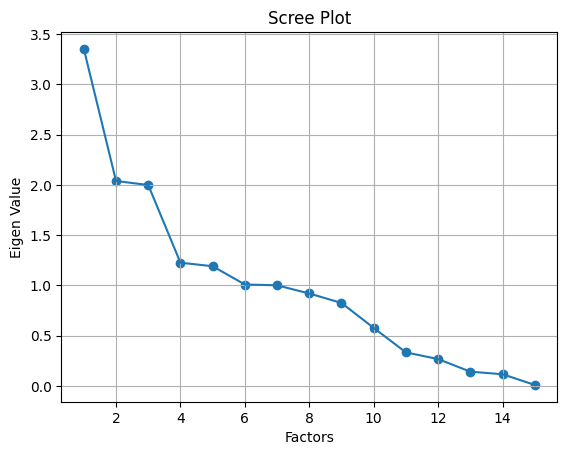

In [173]:
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

#Criterion 1
#Selecting the columns to include in the analysis of factors
columns_for_fa = ['Favourite Genre', 'Average Click Duration', 'Time of Day', 'Movie Preference', 'Average Time per Day', 'Frequent day', 'number_genres', 'Frequent month', 'Total films',
       'Weekday Click Frequency', 'Weekend Click Frequency', 'Year Duration Max', 'Days Since Last Click', 'Number of Films Before 2000', 'percentage']

#Creating a dataframe just with the selected columns
dataframe_for_fa = new_df[columns_for_fa]


#Copying the DataFrame
dataframe_for_fa_copy = dataframe_for_fa.copy()

#Substituting the infinites with NaN values
dataframe_for_fa_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

#Last checking of NaNs
dataframe_for_fa = dataframe_for_fa_copy.dropna()

#Inizialising the object FactorAnalyzer
fa = FactorAnalyzer(rotation=None, impute="drop")

#Fit of the analysis of the factors
fa.fit(dataframe_for_fa)

#Obtaining the eigenvalues
ev, _ = fa.get_eigenvalues()

#Visualising the Scree Plot
plt.scatter(range(1, len(ev) + 1), ev)
plt.plot(range(1, len(ev) + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()
plt.show()

From the graph we can see that the factors with eigenvalues greather than 1 are 6 or 7. Then to be sure about the number of factors, we see the precise values of the eigenvalues.

In [163]:
#Values of the eigenvalues
print(ev)

[3.35338261 2.03856855 1.99889538 1.22558189 1.19022686 1.00845195
 1.00064298 0.91892207 0.82484091 0.57635718 0.33278009 0.26615328
 0.14098258 0.11532129 0.00889238]


As it is possible to see, the factors that have eigenvalues greather than 1 are 7. Then it is confirmed the result of the plot.
Now we use the second criterion and then we compare them.

In [164]:
#Criterion 2
#Calculating the cumulative explained variance
cumulative_variance = np.cumsum(ev/15)
print(cumulative_variance)

[0.22355884 0.35946341 0.4927231  0.57442856 0.65377702 0.72100715
 0.78771668 0.84897815 0.90396755 0.94239136 0.9645767  0.98232025
 0.99171909 0.99940717 1.        ]


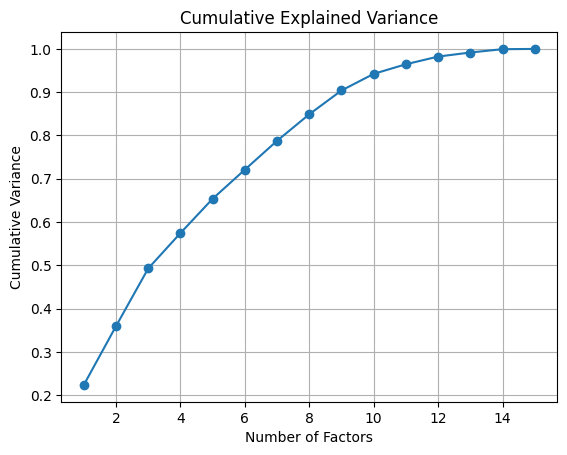

In [165]:
#Visualising the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Factors')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.show()


From the second criterion we can see that 6 factors explain 72.1% of the variance, 7 factors 78.8% and 8 factors 84.9%. The optimal value is usually around 80%, but since the first criterion gave a result of 7 factors and the cumulative explained variance is 78.8%, we confirm 7 factors. Then we can find the final dataset with the 7 new features:

In [174]:
#Factor Analysis with 7 factors
fa = FactorAnalyzer(n_factors=7, rotation=None, impute="drop")
fa.fit(dataframe_for_fa)

#Obtaining the transformed data based on 7 factors
factors_data = fa.transform(dataframe_for_fa)

#Creating a new dataset with the 7 factors
columns_factors = [f'Factor_{i+1}' for i in range(7)]
df_factors = pd.DataFrame(data=factors_data, columns=columns_factors)

# Riporta l'indice originale a new_df_factors
df_factors.reset_index(drop=True, inplace=True)

#Adding the column 'user_id' to the new DataFrame with the factors
df_factors['user_id'] = new_df['user_id']

#Final dataset
df_factors


,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7,user_id
0,-0.600061,1.210708,-0.475202,-0.277647,1.268603,-1.267220,-0.491524,00004e2862
1,2.855487,1.048308,-0.120705,0.379667,0.529839,1.452321,-2.234614,000052a0a0
2,-0.553746,-0.155724,-0.276230,1.021073,-0.089074,0.556295,-0.065641,000090e7c8
3,-0.181540,-0.140007,-0.197540,-1.672055,0.406808,-2.056430,0.326910,000296842d
4,-0.065842,1.182625,-0.234080,-0.123846,-1.254067,-0.027980,0.517676,0002aab109
...,...,...,...,...,...,...,...,...
155843,-0.615313,1.159702,-0.397495,1.884656,0.975033,-0.386719,-0.125581,fffd9bf758
155844,-0.436505,1.166684,-0.383602,-0.915285,-0.371453,0.629496,0.336129,fffe7b777b
155845,1.141876,1.051817,-0.141069,1.626585,1.736147,-0.968358,0.472889,fffeac83be
155846,-0.396322,1.141332,-0.430909,1.390781,1.600394,0.912156,-0.715034,ffff2c5f9e
